# Compose: Training a model to generate music

In [2]:
import os
import pickle
import numpy
import pydot
from matplotlib import pyplot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras import regularizers

from models.GRUAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

## Set parameters

In [8]:
# run params
section = 'compose'
run_id = 'GRU'
genre_name = 'cello'
composer_name='Bach'

run_folder = './run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('./data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'load' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 1
rnn_units = 128
use_attention = True
reg = None
#reg = regularizers.l2(0.05)

## Extract the notes

In [9]:
data_folder

'./data/cello/Bach'

In [10]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)
            #notes.extend(['START'])
            #durations.extend([0])

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

In [11]:
print(notes)

['START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'START', 'B3', 'G2.D3.B3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'B3', 'G3', 'F#3', 'G3', 'E3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A2', 'D3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'B3', 'G3', 'G3', 'D3', 'D3', 'B2', 'B2', 'G2', 'G2', 'B3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'A3', 'G3', 'F#3', 'G3', 'A3', 'E-3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'E3', 'B2', 'B2', 'G2', 'G2', 'E2', 'E2', 'B2', 'E3', 'G3', 'F#3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'C#4', 'G3', 'F#3', 'G3', 'C#4', 'E3', 'F#3', 'G3', 'E3', 'A2', 'G3', 'F#3', 'D3', 'E3', 'F#3', 'D3', 'G3', 'E3', 'F#3', 'D3', 'F#3', 

## Create the lookup tables

In [12]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
#velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
#velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [13]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.A3': 1,
 'A2.B2': 2,
 'A2.C3': 3,
 'A2.C3.D3.E3': 4,
 'A2.D3': 5,
 'A2.E-3': 6,
 'A2.E3': 7,
 'A2.E3.A3': 8,
 'A2.E3.C#4': 9,
 'A2.E3.C#4.A4': 10,
 'A2.E3.C#4.E4': 11,
 'A2.E3.C#4.G#4': 12,
 'A2.E3.C4': 13,
 'A2.E3.D4': 14,
 'A2.F#3': 15,
 'A2.F#3.C4': 16,
 'A2.F#3.D4': 17,
 'A2.F#3.D4.A4': 18,
 'A2.F#3.D4.E4': 19,
 'A2.F#3.D4.F#4': 20,
 'A2.F#4': 21,
 'A2.F3': 22,
 'A2.F3.C4': 23,
 'A2.F3.D4': 24,
 'A2.F3.D4.A4': 25,
 'A2.G3': 26,
 'A2.G3.C#4': 27,
 'A2.G3.D4': 28,
 'A3': 29,
 'A3.B-3': 30,
 'A3.B3': 31,
 'A3.B3.A4': 32,
 'A3.B3.C#4': 33,
 'A3.B3.C4': 34,
 'A3.B3.F#4.G4': 35,
 'A3.B3.G4': 36,
 'A3.C#4': 37,
 'A3.C#4.E4': 38,
 'A3.C4': 39,
 'A3.D4': 40,
 'A3.D4.E4': 41,
 'A3.D4.F#4': 42,
 'A3.E4': 43,
 'A3.E4.F#4': 44,
 'A3.E4.F#4.G4': 45,
 'A3.E4.G4': 46,
 'A3.F#4': 47,
 'A3.F#4.G4': 48,
 'A3.F4': 49,
 'A3.G#4.A4': 50,
 'A3.G4': 51,
 'A4': 52,
 'A4.B4': 53,
 'B-2': 54,
 'B-2.A3': 55,
 'B-2.B-3': 56,
 'B-2.D3': 57,
 'B-2.D3.A3': 58,
 'B-2.D3.E-3.G#3': 59,
 'B-2.D3.G#3': 

In [14]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(2, 3): 7,
 0.75: 8,
 1.0: 9,
 1.25: 10,
 Fraction(4, 3): 11,
 1.5: 12,
 1.75: 13,
 2.0: 14,
 2.25: 15,
 2.5: 16,
 3.0: 17,
 4.0: 18}

## Prepare the sequences used by the Neural Network

In [15]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [16]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460
 460 460 460 460 460 460 460 460 460 460 460 460 460 460]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Create the structure of the neural network

In [17]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention, reg)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 1)      461         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 1)      19          input_2[0][0]                    
____________________________________________________________________________________________

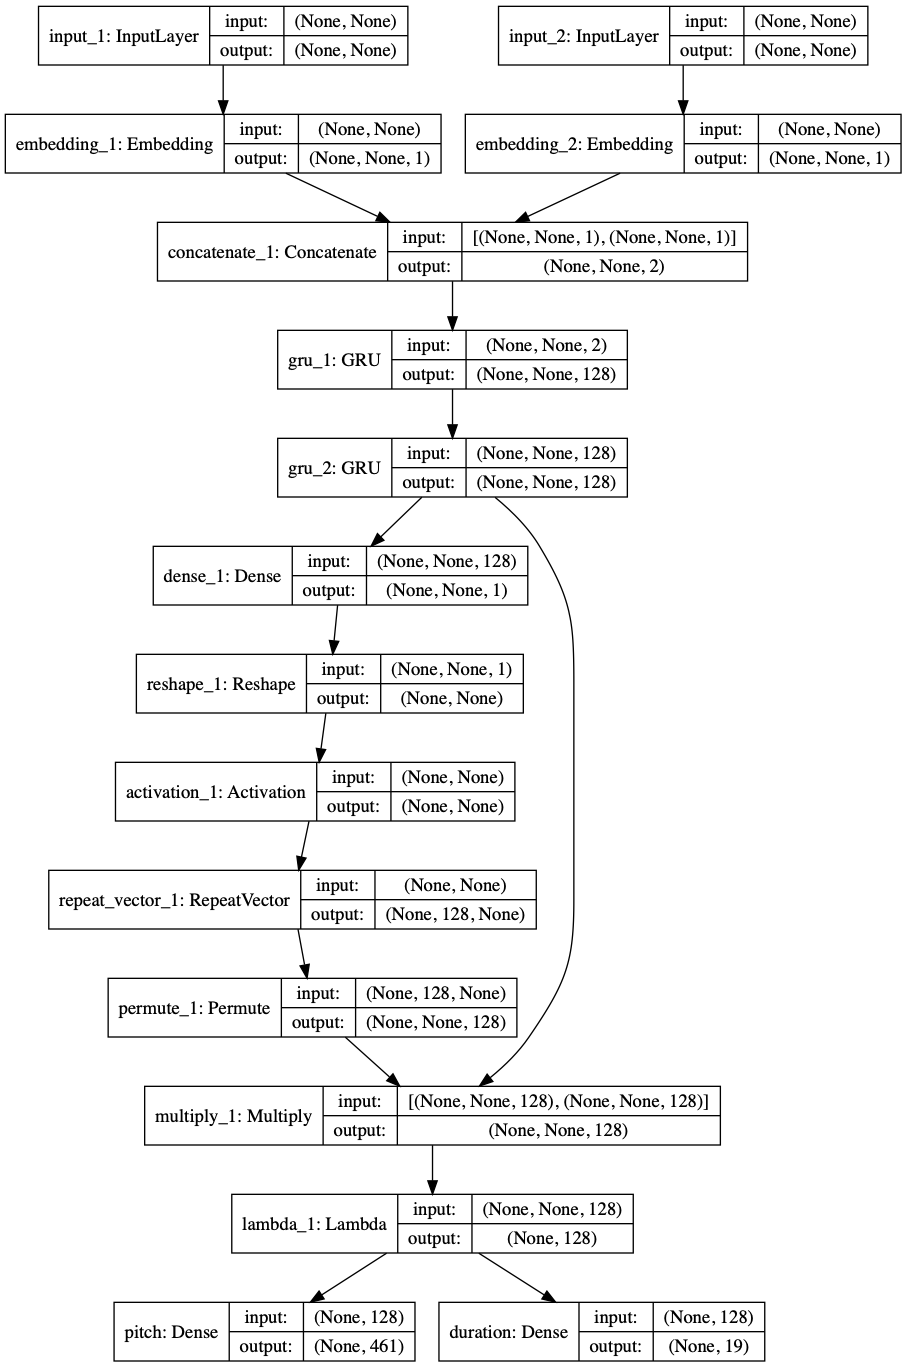

In [18]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [19]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [20]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
history = model.fit(network_input, network_output
          , epochs=20000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

train_history = history.history['loss']
val_history = history.history['val_loss']


/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23024 samples, validate on 5757 samples
Epoch 1/20000
23024/23024 [==============================] - 199s 9ms/step - loss: 4.8166 - pitch_loss: 3.7742 - duration_loss: 1.0417 - val_loss: 4.7337 - val_pitch_loss: 3.5922 - val_duration_loss: 1.1412
Epoch 2/20000
23024/23024 [==============================] - 164s 7ms/step - loss: 4.3730 - pitch_loss: 3.5528 - duration_loss: 0.8198 - val_loss: 4.3808 - val_pitch_loss: 3.3980 - val_duration_loss: 0.9828
Epoch 3/20000
23024/23024 [==============================] - 173s 8ms/step - loss: 4.1501 - pitch_loss: 3.4363 - duration_loss: 0.7132 - val_loss: 4.1211 - val_pitch_loss: 3.2716 - val_duration_loss: 0.8493
Epoch 4/20000
23024/23024 [==============================] - 171s 7ms/step - loss: 4.0093 - pitch_loss: 3.3594 - duration_loss: 0.6498 - val_loss: 4.0863 - val_pitch_loss: 3.2964 - val_duration_loss: 0.7898
Epoch 5/20000
23024/23024 [==============================] - 158s 7ms/step - loss: 3.9297 - pitch_loss: 3.3160 - duration_l

/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


23024/23024 [==============================] - 188s 8ms/step - loss: 3.5478 - pitch_loss: 3.0589 - duration_loss: 0.4885 - val_loss: 4.3116 - val_pitch_loss: 3.2964 - val_duration_loss: 1.0151
Epoch 14/20000
23024/23024 [==============================] - 172s 7ms/step - loss: 3.5090 - pitch_loss: 3.0327 - duration_loss: 0.4765 - val_loss: 4.4161 - val_pitch_loss: 3.3933 - val_duration_loss: 1.0227
Epoch 15/20000
23024/23024 [==============================] - 188s 8ms/step - loss: 3.4720 - pitch_loss: 3.0069 - duration_loss: 0.4652 - val_loss: 4.4054 - val_pitch_loss: 3.4047 - val_duration_loss: 1.0007
Epoch 16/20000
23024/23024 [==============================] - 199s 9ms/step - loss: 3.4397 - pitch_loss: 2.9840 - duration_loss: 0.4561 - val_loss: 4.3885 - val_pitch_loss: 3.4146 - val_duration_loss: 0.9738
Epoch 17/20000
23024/23024 [==============================] - 181s 8ms/step - loss: 3.4143 - pitch_loss: 2.9660 - duration_loss: 0.4480 - val_loss: 4.4242 - val_pitch_loss: 3.4238 - v

23024/23024 [==============================] - 178s 8ms/step - loss: 2.5870 - pitch_loss: 2.3672 - duration_loss: 0.2199 - val_loss: 5.6789 - val_pitch_loss: 4.2855 - val_duration_loss: 1.3937
Epoch 53/20000
23024/23024 [==============================] - 188s 8ms/step - loss: 2.5677 - pitch_loss: 2.3518 - duration_loss: 0.2152 - val_loss: 5.7541 - val_pitch_loss: 4.2768 - val_duration_loss: 1.4776
Epoch 54/20000
23024/23024 [==============================] - 211s 9ms/step - loss: 2.5491 - pitch_loss: 2.3371 - duration_loss: 0.2114 - val_loss: 5.7753 - val_pitch_loss: 4.3062 - val_duration_loss: 1.4694
Epoch 55/20000
23024/23024 [==============================] - 198s 9ms/step - loss: 2.5262 - pitch_loss: 2.3163 - duration_loss: 0.2097 - val_loss: 5.8302 - val_pitch_loss: 4.3403 - val_duration_loss: 1.4902
Epoch 56/20000
23024/23024 [==============================] - 202s 9ms/step - loss: 2.5082 - pitch_loss: 2.2993 - duration_loss: 0.2083 - val_loss: 5.7780 - val_pitch_loss: 4.2988 - v

/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122113). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


23024/23024 [==============================] - 177s 8ms/step - loss: 2.1487 - pitch_loss: 1.9796 - duration_loss: 0.1692 - val_loss: 6.2856 - val_pitch_loss: 4.7154 - val_duration_loss: 1.5707
Epoch 84/20000
23024/23024 [==============================] - 192s 8ms/step - loss: 2.1388 - pitch_loss: 1.9650 - duration_loss: 0.1733 - val_loss: 6.4656 - val_pitch_loss: 4.8505 - val_duration_loss: 1.6154
Epoch 85/20000
23024/23024 [==============================] - 193s 8ms/step - loss: 2.1189 - pitch_loss: 1.9520 - duration_loss: 0.1665 - val_loss: 6.4912 - val_pitch_loss: 4.8221 - val_duration_loss: 1.6692
Epoch 86/20000
23024/23024 [==============================] - 174s 8ms/step - loss: 2.1136 - pitch_loss: 1.9412 - duration_loss: 0.1718 - val_loss: 6.4985 - val_pitch_loss: 4.7812 - val_duration_loss: 1.7177
Epoch 87/20000
23024/23024 [==============================] - 196s 9ms/step - loss: 2.1049 - pitch_loss: 1.9345 - duration_loss: 0.1709 - val_loss: 6.5071 - val_pitch_loss: 4.7955 - v

23024/23024 [==============================] - 112s 5ms/step - loss: 1.8506 - pitch_loss: 1.7010 - duration_loss: 0.1493 - val_loss: 6.9151 - val_pitch_loss: 5.0767 - val_duration_loss: 1.8383
Epoch 123/20000
23024/23024 [==============================] - 106s 5ms/step - loss: 1.8352 - pitch_loss: 1.6910 - duration_loss: 0.1438 - val_loss: 7.0321 - val_pitch_loss: 5.1806 - val_duration_loss: 1.8516
Epoch 124/20000
23024/23024 [==============================] - 111s 5ms/step - loss: 1.8384 - pitch_loss: 1.6953 - duration_loss: 0.1429 - val_loss: 7.1164 - val_pitch_loss: 5.2495 - val_duration_loss: 1.8674
Epoch 125/20000
23024/23024 [==============================] - 106s 5ms/step - loss: 1.8306 - pitch_loss: 1.6859 - duration_loss: 0.1448 - val_loss: 7.1331 - val_pitch_loss: 5.1442 - val_duration_loss: 1.9892
Epoch 126/20000
23024/23024 [==============================] - 105s 5ms/step - loss: 1.8347 - pitch_loss: 1.6898 - duration_loss: 0.1451 - val_loss: 7.0316 - val_pitch_loss: 5.1997

23024/23024 [==============================] - 116s 5ms/step - loss: 1.6220 - pitch_loss: 1.4946 - duration_loss: 0.1274 - val_loss: 7.3627 - val_pitch_loss: 5.4471 - val_duration_loss: 1.9165
Epoch 162/20000
23024/23024 [==============================] - 140s 6ms/step - loss: 1.6362 - pitch_loss: 1.5066 - duration_loss: 0.1296 - val_loss: 7.4038 - val_pitch_loss: 5.5520 - val_duration_loss: 1.8526
Epoch 163/20000
23024/23024 [==============================] - 143s 6ms/step - loss: 1.6358 - pitch_loss: 1.5046 - duration_loss: 0.1309 - val_loss: 7.3425 - val_pitch_loss: 5.4439 - val_duration_loss: 1.8995
Epoch 164/20000
23024/23024 [==============================] - 128s 6ms/step - loss: 1.6227 - pitch_loss: 1.4945 - duration_loss: 0.1287 - val_loss: 7.3763 - val_pitch_loss: 5.4274 - val_duration_loss: 1.9495
Epoch 165/20000
23024/23024 [==============================] - 149s 6ms/step - loss: 1.6244 - pitch_loss: 1.4967 - duration_loss: 0.1278 - val_loss: 7.3046 - val_pitch_loss: 5.3957

23024/23024 [==============================] - 118s 5ms/step - loss: 1.4822 - pitch_loss: 1.3674 - duration_loss: 0.1143 - val_loss: 7.6330 - val_pitch_loss: 5.6576 - val_duration_loss: 1.9767
Epoch 201/20000
23024/23024 [==============================] - 115s 5ms/step - loss: 1.4636 - pitch_loss: 1.3530 - duration_loss: 0.1102 - val_loss: 7.6990 - val_pitch_loss: 5.7220 - val_duration_loss: 1.9777
Epoch 202/20000
23024/23024 [==============================] - 109s 5ms/step - loss: 1.4602 - pitch_loss: 1.3500 - duration_loss: 0.1101 - val_loss: 7.5888 - val_pitch_loss: 5.6405 - val_duration_loss: 1.9489
Epoch 203/20000
23024/23024 [==============================] - 139s 6ms/step - loss: 1.4653 - pitch_loss: 1.3542 - duration_loss: 0.1105 - val_loss: 7.7819 - val_pitch_loss: 5.7725 - val_duration_loss: 2.0099
Epoch 204/20000
23024/23024 [==============================] - 124s 5ms/step - loss: 1.4628 - pitch_loss: 1.3512 - duration_loss: 0.1115 - val_loss: 7.8563 - val_pitch_loss: 5.7250

23024/23024 [==============================] - 108s 5ms/step - loss: 1.3488 - pitch_loss: 1.2465 - duration_loss: 0.1022 - val_loss: 8.0292 - val_pitch_loss: 5.8877 - val_duration_loss: 2.1430
Epoch 240/20000
23024/23024 [==============================] - 127s 6ms/step - loss: 1.3445 - pitch_loss: 1.2388 - duration_loss: 0.1059 - val_loss: 8.0851 - val_pitch_loss: 5.8913 - val_duration_loss: 2.1952
Epoch 241/20000
23024/23024 [==============================] - 130s 6ms/step - loss: 1.3529 - pitch_loss: 1.2462 - duration_loss: 0.1074 - val_loss: 8.1173 - val_pitch_loss: 5.9264 - val_duration_loss: 2.1922
Epoch 242/20000
23024/23024 [==============================] - 150s 7ms/step - loss: 1.3466 - pitch_loss: 1.2438 - duration_loss: 0.1028 - val_loss: 8.0976 - val_pitch_loss: 5.9381 - val_duration_loss: 2.1604
Epoch 243/20000
23024/23024 [==============================] - 109s 5ms/step - loss: 1.3533 - pitch_loss: 1.2495 - duration_loss: 0.1038 - val_loss: 8.2072 - val_pitch_loss: 6.0063

23024/23024 [==============================] - 74s 3ms/step - loss: 1.2473 - pitch_loss: 1.1514 - duration_loss: 0.0974 - val_loss: 8.1361 - val_pitch_loss: 5.9283 - val_duration_loss: 2.2088
Epoch 279/20000
23024/23024 [==============================] - 60s 3ms/step - loss: 1.2350 - pitch_loss: 1.1403 - duration_loss: 0.0947 - val_loss: 8.2739 - val_pitch_loss: 5.9614 - val_duration_loss: 2.3138
Epoch 280/20000
23024/23024 [==============================] - 69s 3ms/step - loss: 1.2526 - pitch_loss: 1.1518 - duration_loss: 0.1011 - val_loss: 8.2889 - val_pitch_loss: 6.1205 - val_duration_loss: 2.1692
Epoch 281/20000
23024/23024 [==============================] - 64s 3ms/step - loss: 1.2512 - pitch_loss: 1.1505 - duration_loss: 0.1009 - val_loss: 8.1842 - val_pitch_loss: 6.0225 - val_duration_loss: 2.1624
Epoch 282/20000
23024/23024 [==============================] - 73s 3ms/step - loss: 1.2348 - pitch_loss: 1.1395 - duration_loss: 0.0948 - val_loss: 8.2310 - val_pitch_loss: 6.1293 - va

23024/23024 [==============================] - 103s 4ms/step - loss: 1.1597 - pitch_loss: 1.0689 - duration_loss: 0.0910 - val_loss: 8.4563 - val_pitch_loss: 6.2449 - val_duration_loss: 2.2126
Epoch 318/20000
23024/23024 [==============================] - 105s 5ms/step - loss: 1.1538 - pitch_loss: 1.0615 - duration_loss: 0.0922 - val_loss: 8.4494 - val_pitch_loss: 6.2432 - val_duration_loss: 2.2080
Epoch 319/20000
23024/23024 [==============================] - 110s 5ms/step - loss: 1.1611 - pitch_loss: 1.0751 - duration_loss: 0.0857 - val_loss: 8.5259 - val_pitch_loss: 6.2777 - val_duration_loss: 2.2494
Epoch 320/20000
23024/23024 [==============================] - 102s 4ms/step - loss: 1.1547 - pitch_loss: 1.0668 - duration_loss: 0.0879 - val_loss: 8.4220 - val_pitch_loss: 6.2386 - val_duration_loss: 2.1848
Epoch 321/20000
23024/23024 [==============================] - 106s 5ms/step - loss: 1.1597 - pitch_loss: 1.0668 - duration_loss: 0.0930 - val_loss: 8.5938 - val_pitch_loss: 6.2800

23024/23024 [==============================] - 56s 2ms/step - loss: 1.0987 - pitch_loss: 1.0125 - duration_loss: 0.0874 - val_loss: 8.3964 - val_pitch_loss: 6.2763 - val_duration_loss: 2.1211
Epoch 357/20000
23024/23024 [==============================] - 54s 2ms/step - loss: 1.0765 - pitch_loss: 0.9968 - duration_loss: 0.0800 - val_loss: 8.5183 - val_pitch_loss: 6.3140 - val_duration_loss: 2.2057
Epoch 358/20000
23024/23024 [==============================] - 56s 2ms/step - loss: 1.1079 - pitch_loss: 1.0175 - duration_loss: 0.0906 - val_loss: 8.5852 - val_pitch_loss: 6.3557 - val_duration_loss: 2.2311
Epoch 359/20000
23024/23024 [==============================] - 54s 2ms/step - loss: 1.0922 - pitch_loss: 1.0075 - duration_loss: 0.0850 - val_loss: 8.4583 - val_pitch_loss: 6.2671 - val_duration_loss: 2.1927
Epoch 360/20000
23024/23024 [==============================] - 54s 2ms/step - loss: 1.0993 - pitch_loss: 1.0151 - duration_loss: 0.0839 - val_loss: 8.4960 - val_pitch_loss: 6.2955 - va

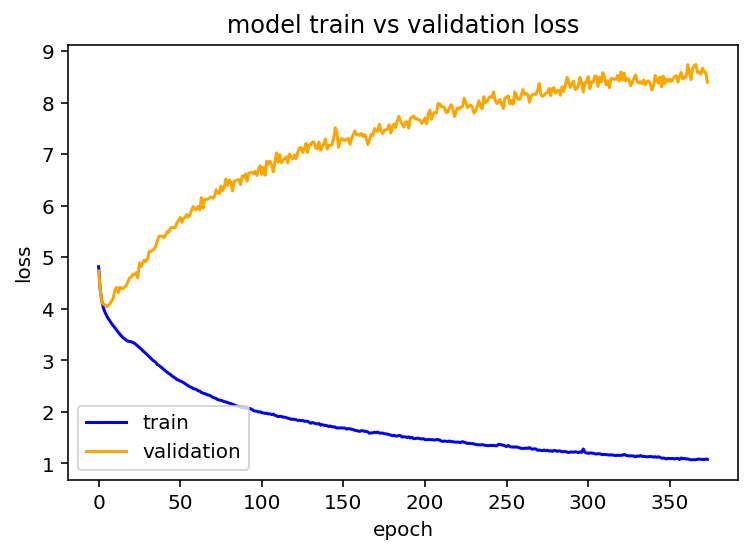

In [21]:
pyplot.plot(train_history, color='blue', label='train')
pyplot.plot(val_history, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower left')
pyplot.show()